# Functions and Libs


In [9]:
from stockanalysis.data import *
from stockanalysis.encoder import *

from stockanalysis.utils import *



# from stockanalysis.param import *


# from stockanalysis.predict import *



In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns

In [3]:
import datetime
import joblib


In [4]:
def split_timeseries(   scaled_data,
                     
                         data,
                         sequence_size=21,
                         y_len=1):
    
        # Create the training data set
        # Create the scaled training data set
        train_data = scaled_data
        y = data
        #breakpoint()
        # Split the data into x_train and y_train data sets
        x_train = []
        y_train = []

        
        for i in range(sequence_size, len(train_data)):
            if len(y[i:i+y_len]) < y_len:
                break

            x_train.append(train_data[i - sequence_size:i, :])
            y_train.append(y[i:i+y_len])

            if i <= sequence_size+1:
                # print(x_train)
                # print(y_train)
                print('i <= sequence_size+1')


        # Convert the x_train and y_train to numpy arrays
        x_train, y_train = np.array(x_train), np.array(y_train)
        # Reshape the data

        #y_train = np.reshape(y_train, (y_train.shape[0],Y_LEN))

        # x_train.shape
        return x_train,y_train

In [20]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import RMSprop


def create_model_manystocks(X_train, y_train):
    
    
#     tf.random.set_seed(30)
    normalizer = Normalization() # Instantiate a "normalizer" layer
    normalizer.adapt(X_train) # "Fit" it on the train set
    model = Sequential()
    model.add(normalizer)
    
    model.add(layers.LSTM(40, return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))
#     model.add(layers.LSTM(40, return_sequences=False, recurrent_dropout=0.3))


    # model.add(layers.LSTM(5))
#     model.add(layers.Dropout(0.2))
    model.add(layers.Dense(20, activation='relu'))
    
    model.add(layers.Dropout(0.2))
    
    
    # model.add(layers.Dense(y_train.shape[1], activation='relu'))
    model.add(layers.Dense(y_train.shape[-1], activation='linear'))
    
    
    model.compile(loss='mse',optimizer=RMSprop(learning_rate=0.008), metrics=['mae', 'mape'])
    # model.compile(loss='mse',optimizer='rmsprop', metrics=['mae', 'mape'])
    print(model.summary())
    print(X_train.shape)
    
    
    return model





In [22]:
from tensorflow.keras.callbacks import EarlyStopping

def train(X_train, y_train, model):
    
    
    
    '''returns a trained pipelined model'''
    es = EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    
    
    
    
    #breakpoint()
    train_size = 0.9
    train_sample = int(train_size * X_train.shape[0])
    X_train, y_train, X_val, y_val = X_train[:train_sample], y_train[:train_sample], X_train[train_sample:], y_train[train_sample:]

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=es,batch_size=128)

    #model.fit(x_train,y_train,epochs=100,)
    
    return model, history




# Generic Modeling for multiple Stocks


## Dealing with :


###### 1)Stocks that has less data them others 


In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data1 = pd.read_html(url,skiprows=1)[0]
data1


,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
0,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
1,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
499,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
502,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [11]:
import datetime


In [36]:
tickers = ["AAPL", "INFY.NS", "TCS", 'GOOG', 'MSFT']

tickers = data1['MMM']

columns = ['Date','Volume', 'rsi','Close','ema55','macd_signal', 'macd_line', 'adx', 'vwap']
# columns = ['Date','Close']


# COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume', 'ema12', 'ema21',
#        'ema26', 'ema34', 'ema55', 'ema99', 'ema200', 'hma12', 'hma21', 'hma26',
#        'hma34', 'hma55', 'hma99', 'hma200', 'rsi', 'atr', 'bb_upper',
#        'bb_lower', 'macd_signal', 'macd_line', 'adx', 'vwap']

merged_df = pd.DataFrame(columns = columns)
dicti = {}

for ticker in tickers:
    print(ticker)
    start_date = (datetime.datetime.now() - datetime.timedelta(days=5 * 365)).strftime("%Y-%m-%d")
    end_date = datetime.datetime.now().strftime("%Y-%m-%d")
    tmp_df = get_technical(symbol=ticker, start=start_date,

                                     end=end_date)[columns]
    dicti[ticker] =  tmp_df
    tmp_df = tmp_df.rename(columns = {'Close': f"Close_{ticker}"})
    
    
    
    if merged_df.shape[0] == 0:

        merged_df = tmp_df.copy()
    else:

        
        merged_df = merged_df.merge(tmp_df, on = 'Date')
    

    
    
    

AOS
[*********************100%***********************]  1 of 1 completed
ABT
[*********************100%***********************]  1 of 1 completed
ABBV
[*********************100%***********************]  1 of 1 completed
ABMD
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ACN
[*********************100%***********************]  1 of 1 completed
ATVI
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ADM
[*********************100%***********************]  1 of 1 completed
ADBE
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ADP
[*********************100%***********************]  1 of 1 completed
AAP
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AES
[*********************100%***********************]  1 of 1 completed
AFL
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


A
[*********************100%***********************]  1 of 1 completed
AIG
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


APD
[*********************100%***********************]  1 of 1 completed
AKAM
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ALK
[*********************100%***********************]  1 of 1 completed
ALB
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ARE
[*********************100%***********************]  1 of 1 completed
ALGN
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ALLE
[*********************100%***********************]  1 of 1 completed
LNT
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ALL
[*********************100%***********************]  1 of 1 completed
GOOGL
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


GOOG
[*********************100%***********************]  1 of 1 completed
MO
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AMZN
[*********************100%***********************]  1 of 1 completed
AMCR
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AMD
[*********************100%***********************]  1 of 1 completed
AEE
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AAL
[*********************100%***********************]  1 of 1 completed
AEP
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AXP
[*********************100%***********************]  1 of 1 completed
AMT
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AWK
[*********************100%***********************]  1 of 1 completed
AMP
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ABC
[*********************100%***********************]  1 of 1 completed
AME
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AMGN
[*********************100%***********************]  1 of 1 completed
APH
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ADI
[*********************100%***********************]  1 of 1 completed
ANSS
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ANTM
[*********************100%***********************]  1 of 1 completed
AON
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


APA
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AMAT
[*********************100%***********************]  1 of 1 completed
APTV
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ANET
[*********************100%***********************]  1 of 1 completed
AIZ
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


T
[*********************100%***********************]  1 of 1 completed
ATO
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


ADSK
[*********************100%***********************]  1 of 1 completed
AZO
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


AVB
[*********************100%***********************]  1 of 1 completed
AVY
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


BKR
[*********************100%***********************]  1 of 1 completed
BLL
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


BAC
[*********************100%***********************]  1 of 1 completed
BBWI
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


BAX
[*********************100%***********************]  1 of 1 completed
BDX
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_42423/1317160952.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'macd_line_x', 'adx_x', 'Volume_x', 'macd_signal_x', 'vwap_x', 'ema55_x', 'rsi_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = merged_df.merge(tmp_df, on = 'Date')


WRB
[*********************100%***********************]  1 of 1 completed
BRK.B
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted


TypeError: 'NoneType' object is not subscriptable

In [13]:
merged_df


,Date,Volume_x,rsi_x,Close_AOS,ema55_x,macd_signal_x,macd_line_x,adx_x,vwap_x,Volume_y,...,adx_y,vwap_y,Volume,rsi,Close_WRB,ema55,macd_signal,macd_line,adx,vwap
0,2018-01-23,655600,77.509682,66.800003,62.272312,1.432630,1.078334,36.921406,66.786669,8122100,...,30.919389,235.303335,477150,65.647965,48.026669,46.359863,0.216431,0.065773,23.481564,47.940001
1,2018-01-24,900700,77.509682,66.800003,62.434015,1.452107,1.153088,39.295593,66.970001,11704900,...,33.256713,237.706665,531000,63.186223,47.860001,46.413439,0.275658,0.107750,24.669086,47.873333
2,2018-02-13,773900,45.473098,62.730000,63.018628,-0.546912,0.048265,37.826853,62.346666,5816600,...,42.182063,215.253332,513900,36.869328,45.480000,46.667638,-0.308930,0.047854,28.327266,45.273333
3,2018-02-15,1186700,56.038902,65.230003,63.133470,-0.248877,-0.088472,35.176765,64.820002,3871900,...,41.199636,221.503332,379500,47.330159,46.493332,46.648292,-0.282744,-0.074793,26.356771,46.386667
4,2018-02-16,1723900,57.190392,65.540001,63.219417,-0.075556,-0.085889,33.033981,65.630002,7849200,...,40.090372,223.000000,738900,47.913695,46.553333,46.644901,-0.256952,-0.111225,25.204143,46.502223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,2022-03-08,1114600,31.981779,66.209999,73.914312,-2.379985,-2.404169,39.654767,66.830002,6694000,...,18.278582,268.573334,913300,51.630758,89.230003,86.602670,0.785073,1.143786,14.916400,89.873334
819,2022-03-09,843000,38.521298,67.680000,73.691658,-2.281569,-2.379649,39.748961,67.760002,5004700,...,17.049524,265.536662,1210100,58.688668,91.680000,86.784003,0.890816,1.093192,15.015094,91.570002
820,2022-03-10,759000,35.821594,66.610001,73.438742,-2.263817,-2.356483,40.221201,66.573334,4377600,...,17.288771,259.043335,738400,61.480469,92.809998,86.999217,1.053654,1.085284,15.332551,92.179998
821,2022-03-11,1090500,33.705630,65.720001,73.163073,-2.295108,-2.344208,40.124818,66.360001,8012400,...,17.898647,255.889994,869200,65.058635,94.400002,87.263531,1.296065,1.127440,16.416566,94.286667


In [14]:
target_columns = [col for col in merged_df.columns if 'Close' in col]
target_columns


['Close_AOS',
 'Close_ABT',
 'Close_ABBV',
 'Close_ABMD',
 'Close_ACN',
 'Close_ATVI',
 'Close_ADM',
 'Close_ADBE',
 'Close_ADP',
 'Close_AAP',
 'Close_AES',
 'Close_AFL',
 'Close_A',
 'Close_AIG',
 'Close_APD',
 'Close_AKAM',
 'Close_ALK',
 'Close_ALB',
 'Close_ARE',
 'Close_ALGN',
 'Close_ALLE',
 'Close_LNT',
 'Close_ALL',
 'Close_GOOGL',
 'Close_GOOG',
 'Close_MO',
 'Close_AMZN',
 'Close_AMCR',
 'Close_AMD',
 'Close_AEE',
 'Close_AAL',
 'Close_AEP',
 'Close_AXP',
 'Close_AMT',
 'Close_AWK',
 'Close_AMP',
 'Close_ABC',
 'Close_AME',
 'Close_AMGN',
 'Close_APH',
 'Close_ADI',
 'Close_ANSS',
 'Close_ANTM',
 'Close_AON',
 'Close_APA',
 'Close_AAPL',
 'Close_AMAT',
 'Close_APTV',
 'Close_ANET',
 'Close_AIZ',
 'Close_T',
 'Close_ATO',
 'Close_ADSK',
 'Close_AZO',
 'Close_AVB',
 'Close_AVY',
 'Close_BKR',
 'Close_BLL',
 'Close_BAC',
 'Close_BBWI',
 'Close_BAX',
 'Close_BDX',
 'Close_WRB']

In [15]:
len_ = int(0.80*merged_df.shape[0])
df_train_dataset = merged_df[:len_]
df_test_dataset = merged_df[len_:]


In [16]:
df_train_dataset.shape, df_test_dataset.shape


((658, 505), (165, 505))

In [17]:
X_train,y_train = split_timeseries(df_train_dataset.drop(columns = 'Date').to_numpy(), np.log(df_train_dataset[target_columns]).to_numpy())


i <= sequence_size+1
i <= sequence_size+1


In [18]:
X_train.shape,y_train.shape


((637, 21, 504), (637, 1, 63))

In [23]:
PATIENCE=20
model = create_model_manystocks(X_train, y_train)

model, history = train(X_train, y_train, model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 504)        1009      
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 40)                87200     
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 63)                1323      
                                                                 
Total params: 90,352
Trainable params: 89,343
Non-trainable params: 1,009
______________________________________________

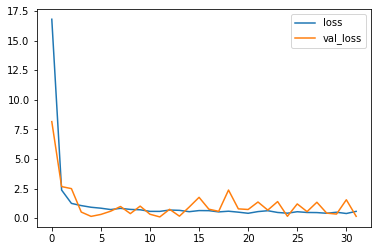

In [24]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()


plt.show()







In [25]:
X_test,y_test = split_timeseries(df_test_dataset.drop(columns = 'Date').to_numpy(), np.log(df_test_dataset[target_columns]).to_numpy())
y_pred = model.predict(X_test)
print(y_pred.shape)

display(df_test_dataset.head())










i <= sequence_size+1
i <= sequence_size+1
(144, 63)


,Date,Volume_x,rsi_x,Close_AOS,ema55_x,macd_signal_x,macd_line_x,adx_x,vwap_x,Volume_y,...,adx_y,vwap_y,Volume,rsi,Close_WRB,ema55,macd_signal,macd_line,adx,vwap
658,2021-07-20,1408700,50.783534,70.199997,69.293724,0.245265,0.408529,11.689478,69.983332,4678400,...,12.566704,247.886663,711000,50.918176,75.849998,75.921599,-0.087657,-0.222633,18.318517,75.630000
659,2021-07-21,565700,53.313497,70.730003,69.345019,0.260399,0.378903,10.993540,70.636668,4285300,...,12.536231,246.030004,453100,53.426029,76.500000,75.942256,-0.003101,-0.178727,17.066219,76.620000
660,2021-07-22,899400,43.723060,68.629997,69.319483,0.101766,0.323476,11.557768,69.296664,6958000,...,11.737337,248.240000,695000,48.166063,75.209999,75.916104,-0.039723,-0.150926,16.182567,75.636665
661,2021-07-23,770900,48.476126,69.629997,69.330573,0.056094,0.269999,12.081694,69.306666,4736100,...,11.463027,250.750000,895600,46.632933,74.809998,75.876600,-0.099873,-0.140715,16.104754,75.153333
662,2021-07-26,735300,49.306086,69.809998,69.347695,0.034031,0.222806,12.258900,69.726667,4954800,...,10.849175,249.813329,687300,45.616572,74.550003,75.829222,-0.166601,-0.145892,16.032498,74.716667


In [26]:
df_pred = pd.DataFrame(np.exp(y_pred))
df_pred.columns = target_columns
df_pred








,Close_AOS,Close_ABT,Close_ABBV,Close_ABMD,Close_ACN,Close_ATVI,Close_ADM,Close_ADBE,Close_ADP,Close_AAP,...,Close_AZO,Close_AVB,Close_AVY,Close_BKR,Close_BLL,Close_BAC,Close_BBWI,Close_BAX,Close_BDX,Close_WRB
0,58.084576,101.072159,84.538719,228.904251,182.064835,57.020500,39.400913,346.595978,123.415184,159.977814,...,1106.259644,186.125259,124.206337,22.686003,80.944794,31.951109,17.937658,77.349434,217.705948,63.476185
1,58.419086,102.172852,85.341515,232.575821,184.806396,57.847610,39.939201,351.536407,126.176933,161.592056,...,1126.371704,188.015717,125.780754,22.759954,81.465477,32.330940,18.119196,78.492546,221.158798,64.369225
2,58.201630,101.371788,84.736183,229.662781,182.678513,57.186672,39.499184,347.874084,123.894791,160.391800,...,1111.384155,186.744080,124.555565,22.719198,81.117317,32.034252,17.974669,77.541176,218.510010,63.650257
3,58.180897,101.290672,84.672409,229.363251,182.462189,57.119167,39.453274,347.508636,123.660530,160.269775,...,1109.907593,186.625717,124.430710,22.715706,81.084480,32.005531,17.959496,77.441040,218.251846,63.576149
4,57.548801,99.138092,82.826614,221.253387,177.297699,55.584362,38.502823,338.290009,118.221519,157.051819,...,1069.354248,183.476852,120.861099,22.684116,80.523567,31.319496,17.643969,75.067307,212.196136,61.958977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,12.705425,20.094934,20.426453,26.322031,26.178797,12.315161,11.905662,44.300571,21.049421,24.705696,...,109.966499,35.429638,22.562370,8.170113,19.915834,9.965878,6.344273,15.854846,35.273342,15.779654
140,12.361453,18.944029,19.695412,25.486441,25.441648,12.063137,11.763114,42.346401,20.587477,24.077906,...,100.098038,32.983990,21.705282,8.007486,19.190281,9.546205,6.245426,15.664091,33.564037,15.287869
141,13.505982,22.342743,23.655970,29.150867,29.443823,13.505471,12.837775,49.708801,23.230898,27.406403,...,129.535324,39.061207,25.217524,8.610683,21.408484,10.864416,6.886691,17.371340,39.547394,17.387627
142,12.541360,20.836369,23.640131,27.475990,28.017572,12.877138,12.118358,45.100670,22.034416,25.692978,...,119.810471,36.561874,23.964230,8.247577,20.067152,10.466716,6.725410,16.706320,37.855846,16.417887


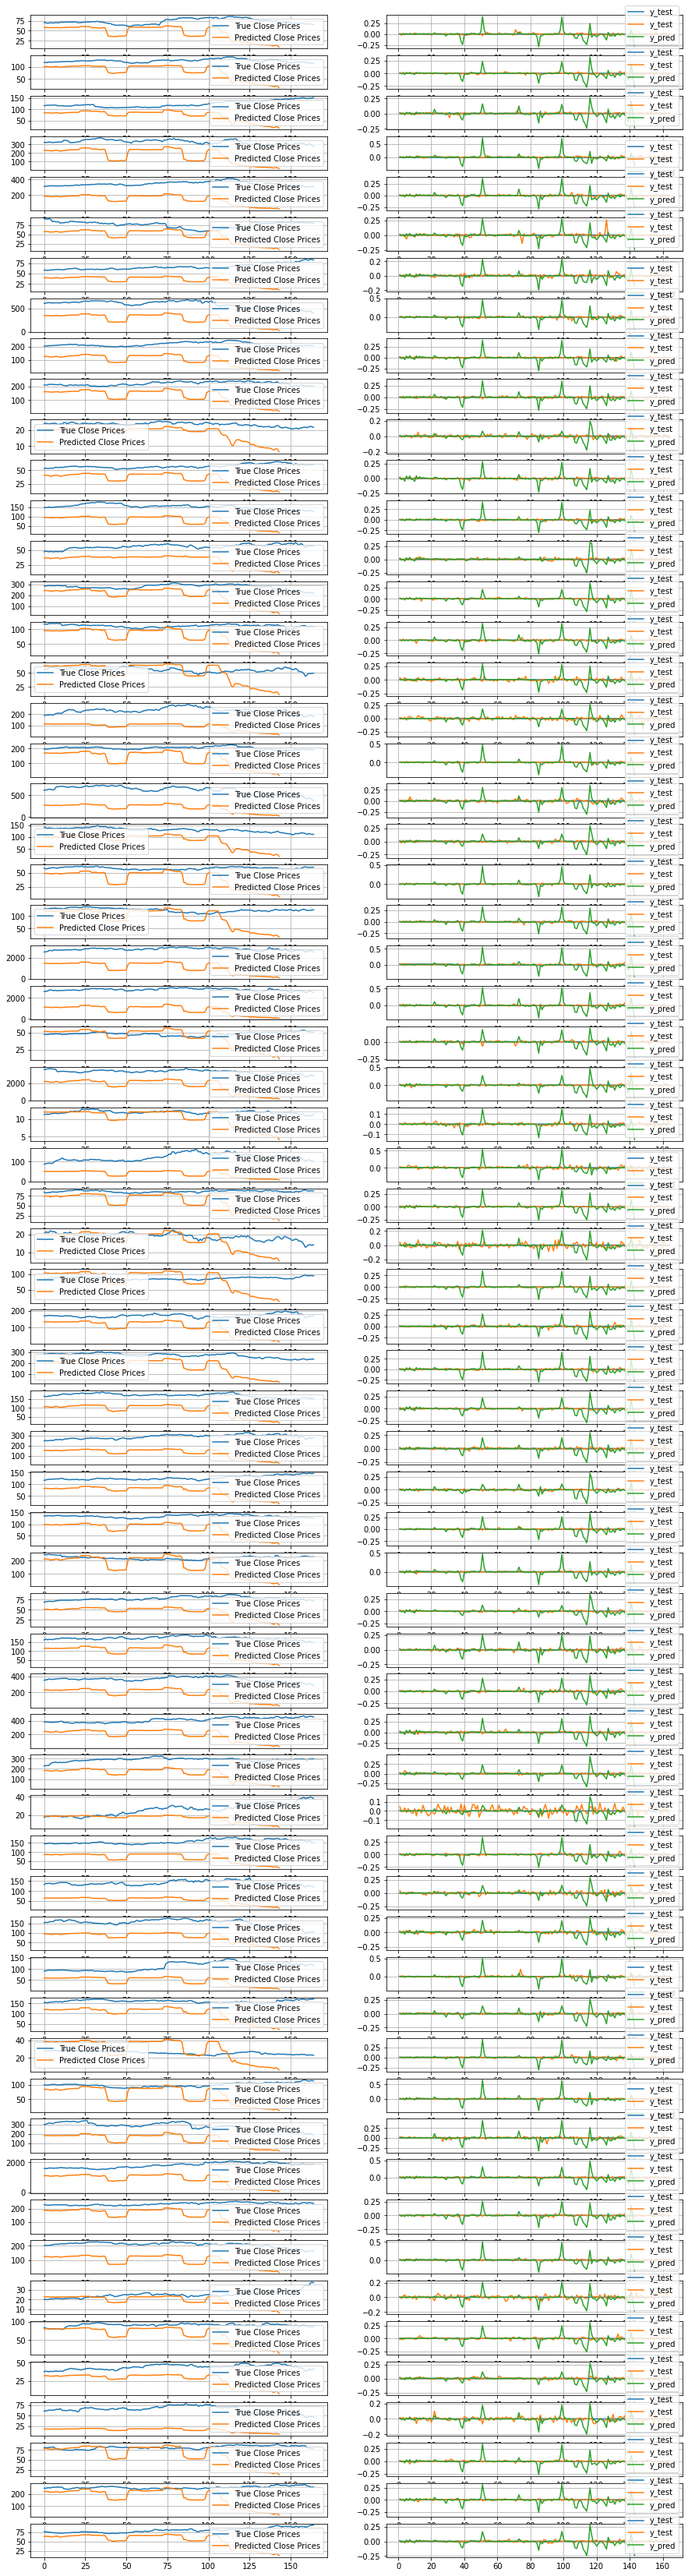

In [27]:
fig = plt.figure(figsize= (15,60))

graph_number = y_train.shape[-1]

for i, column in enumerate(target_columns, start = 1):
    
    if i == 1:
        count = i
    else:
        count +=1
    axs = fig.add_subplot(graph_number,2,count)
    
    
    
    axs.plot(df_test_dataset[column].to_numpy(), label = 'True Close Prices')
    axs.plot(df_pred[column], label = 'Predicted Close Prices')
    axs.grid()
    
    plt.legend()
    
    count +=1
    axs = fig.add_subplot(graph_number,2,count)
    
    
    axs.plot(df_test_dataset[column].reset_index().pct_change(), label= 'y_test')
    axs.plot(df_pred[column].pct_change(), label= 'y_pred')
    axs.grid()
    plt.legend()
    
plt.show()    




# Kmeans


In [ ]:
# timestamp	Asset_ID	Count	Open	High	Low	Close	Volume	VWAP

In [35]:
list(merged_df.columns[1:]) + 'bla'





TypeError: can only concatenate list (not "str") to list

In [34]:
merged_df


,Date,Volume_x,rsi_x,Close_AOS,ema55_x,macd_signal_x,macd_line_x,adx_x,vwap_x,Volume_y,...,adx_y,vwap_y,Volume,rsi,Close_WRB,ema55,macd_signal,macd_line,adx,vwap
0,2018-01-23,655600,77.509682,66.800003,62.272312,1.432630,1.078334,36.921406,66.786669,8122100,...,30.919389,235.303335,477150,65.647965,48.026669,46.359863,0.216431,0.065773,23.481564,47.940001
1,2018-01-24,900700,77.509682,66.800003,62.434015,1.452107,1.153088,39.295593,66.970001,11704900,...,33.256713,237.706665,531000,63.186223,47.860001,46.413439,0.275658,0.107750,24.669086,47.873333
2,2018-02-13,773900,45.473098,62.730000,63.018628,-0.546912,0.048265,37.826853,62.346666,5816600,...,42.182063,215.253332,513900,36.869328,45.480000,46.667638,-0.308930,0.047854,28.327266,45.273333
3,2018-02-15,1186700,56.038902,65.230003,63.133470,-0.248877,-0.088472,35.176765,64.820002,3871900,...,41.199636,221.503332,379500,47.330159,46.493332,46.648292,-0.282744,-0.074793,26.356771,46.386667
4,2018-02-16,1723900,57.190392,65.540001,63.219417,-0.075556,-0.085889,33.033981,65.630002,7849200,...,40.090372,223.000000,738900,47.913695,46.553333,46.644901,-0.256952,-0.111225,25.204143,46.502223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,2022-03-08,1114600,31.981779,66.209999,73.914312,-2.379985,-2.404169,39.654767,66.830002,6694000,...,18.278582,268.573334,913300,51.630758,89.230003,86.602670,0.785073,1.143786,14.916400,89.873334
819,2022-03-09,843000,38.521298,67.680000,73.691658,-2.281569,-2.379649,39.748961,67.760002,5004700,...,17.049524,265.536662,1210100,58.688668,91.680000,86.784003,0.890816,1.093192,15.015094,91.570002
820,2022-03-10,759000,35.821594,66.610001,73.438742,-2.263817,-2.356483,40.221201,66.573334,4377600,...,17.288771,259.043335,738400,61.480469,92.809998,86.999217,1.053654,1.085284,15.332551,92.179998
821,2022-03-11,1090500,33.705630,65.720001,73.163073,-2.295108,-2.344208,40.124818,66.360001,8012400,...,17.898647,255.889994,869200,65.058635,94.400002,87.263531,1.296065,1.127440,16.416566,94.286667


In [38]:
dicti.keys()






dict_keys(['AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'AIG', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ANET', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB'])

In [44]:
pd.concat([dicti['AOS'], dicti['ABT']]).sort_values(by = 'Date')


          




,Date,Volume,rsi,Close,ema55,macd_signal,macd_line,adx,vwap
0,2018-01-18,507700,76.776193,65.910004,61.733802,1.139072,0.791066,29.470947,65.816668
0,2018-01-18,5658600,66.897087,59.070000,56.533171,0.800144,0.819504,36.909498,58.956666
1,2018-01-19,7362300,68.782208,59.310001,56.632344,0.799319,0.815467,37.054742,59.316667
1,2018-01-19,635200,80.684124,67.040001,61.923309,1.288067,0.890467,32.115281,66.680000
2,2018-01-22,929000,80.169842,67.000000,62.104619,1.386932,0.989760,34.579322,66.829999
...,...,...,...,...,...,...,...,...,...
1043,2022-03-10,759000,35.821594,66.610001,73.438742,-2.263817,-2.356483,40.221201,66.573334
1044,2022-03-11,8012400,35.181515,114.019997,124.278139,-2.605659,-2.400671,38.452642,115.319997
1044,2022-03-11,1090500,33.705630,65.720001,73.163073,-2.295108,-2.344208,40.124818,66.360001
1045,2022-03-14,766600,34.455189,65.879997,72.902963,-2.280705,-2.331507,40.249352,65.843333


In [51]:
kmeans_df = pd.DataFrame()
for key, df in dicti.items():
    df['stock'] = key
    
    if kmeans_df.shape == 0:
        kmeans_df = df.copy()
    else:
        kmeans_df = pd.concat([kmeans_df, df])

        
        
    


In [54]:
kmeans_df = kmeans_df.sort_values(by = 'Date')





In [73]:

X = kmeans_df.groupby('stock')[kmeans_df.columns[1:]].agg(['mean', 'std', 'max', 'min', 'median'])
y = X.index






/tmp/ipykernel_42423/3680646899.py:1: FutureWarning:

['stock'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



In [75]:
X.head(), y



(             Volume                                                      \
                mean           std          max         min       median   
 stock                                                                     
 A      2.062936e+06  1.118186e+06   14523800.0    271900.0    1816150.0   
 AAL    3.111831e+07  3.714820e+07  428617100.0   2373600.0   18411800.0   
 AAP    9.938754e+05  5.119161e+05    5903800.0    270100.0     890400.0   
 AAPL   1.230142e+08  5.756159e+07  426510000.0  41000000.0  108354850.0   
 ABBV   7.845498e+06  4.817790e+06   90131800.0   1378600.0    6702650.0   
 
              rsi                                              ...        adx  \
             mean        std        max        min     median  ...       mean   
 stock                                                         ...              
 A      54.452309  12.605823  91.541518  21.693766  55.023477  ...  25.956202   
 AAL    47.811010  11.059048  80.828174  16.790163  47.756661  ...

In [79]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)


X_pca = pca.fit_transform(X_scaled)




/home/thierry/.pyenv/versions/3.8.12/envs/stockanalysis/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/home/thierry/.pyenv/versions/3.8.12/envs/stockanalysis/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [80]:
X_pca.shape




(63, 2)

In [78]:
len(y)



63

In [57]:
import plotly.express as px


In [81]:
px.scatter(x=X_pca[:,0], y=X_pca[:,1], color = y)



Text(0.5, 0, 'k cluster number')

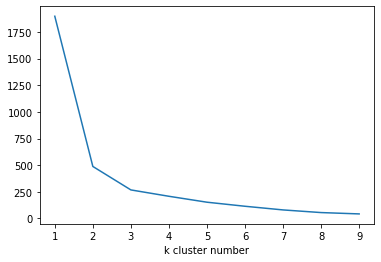

In [82]:
inertias = []
ks = range(1,10)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_pca)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

# S&P500 Exploration


In [83]:
data1



,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
0,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
1,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
499,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
502,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [84]:
merged_df



,Date,Volume_x,rsi_x,Close_AOS,ema55_x,macd_signal_x,macd_line_x,adx_x,vwap_x,Volume_y,...,adx_y,vwap_y,Volume,rsi,Close_WRB,ema55,macd_signal,macd_line,adx,vwap
0,2018-01-23,655600,77.509682,66.800003,62.272312,1.432630,1.078334,36.921406,66.786669,8122100,...,30.919389,235.303335,477150,65.647965,48.026669,46.359863,0.216431,0.065773,23.481564,47.940001
1,2018-01-24,900700,77.509682,66.800003,62.434015,1.452107,1.153088,39.295593,66.970001,11704900,...,33.256713,237.706665,531000,63.186223,47.860001,46.413439,0.275658,0.107750,24.669086,47.873333
2,2018-02-13,773900,45.473098,62.730000,63.018628,-0.546912,0.048265,37.826853,62.346666,5816600,...,42.182063,215.253332,513900,36.869328,45.480000,46.667638,-0.308930,0.047854,28.327266,45.273333
3,2018-02-15,1186700,56.038902,65.230003,63.133470,-0.248877,-0.088472,35.176765,64.820002,3871900,...,41.199636,221.503332,379500,47.330159,46.493332,46.648292,-0.282744,-0.074793,26.356771,46.386667
4,2018-02-16,1723900,57.190392,65.540001,63.219417,-0.075556,-0.085889,33.033981,65.630002,7849200,...,40.090372,223.000000,738900,47.913695,46.553333,46.644901,-0.256952,-0.111225,25.204143,46.502223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,2022-03-08,1114600,31.981779,66.209999,73.914312,-2.379985,-2.404169,39.654767,66.830002,6694000,...,18.278582,268.573334,913300,51.630758,89.230003,86.602670,0.785073,1.143786,14.916400,89.873334
819,2022-03-09,843000,38.521298,67.680000,73.691658,-2.281569,-2.379649,39.748961,67.760002,5004700,...,17.049524,265.536662,1210100,58.688668,91.680000,86.784003,0.890816,1.093192,15.015094,91.570002
820,2022-03-10,759000,35.821594,66.610001,73.438742,-2.263817,-2.356483,40.221201,66.573334,4377600,...,17.288771,259.043335,738400,61.480469,92.809998,86.999217,1.053654,1.085284,15.332551,92.179998
821,2022-03-11,1090500,33.705630,65.720001,73.163073,-2.295108,-2.344208,40.124818,66.360001,8012400,...,17.898647,255.889994,869200,65.058635,94.400002,87.263531,1.296065,1.127440,16.416566,94.286667


In [85]:
def log_return(series, periods=1):
    
    return np.log(series).diff(periods=periods)


In [86]:
lret_btc_long = log_return(merged_df['Close_AMZN'])[1:]
lret_eth_long = log_return(merged_df['Close_GOOG'])[1:]
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)
two_assets

# group consecutive rows and use .corr() for correlation between columns
# corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]
corr_time = two_assets.groupby(two_assets.index).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]




# corr_time.plot();
# plt.xticks([])
# plt.ylabel("Correlation")
# plt.title("Correlation between BTC and ETH over time");


In [87]:
two_assets['Date'] = merged_df['Date']
two_assets['Month'] = two_assets.Date.dt.month
two_assets['Year'] = two_assets.Date.dt.year
two_assets['week'] = two_assets.Date.dt.week
two_assets['day'] = two_assets.Date.dt.day







/tmp/ipykernel_42423/4128761960.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



<AxesSubplot:>

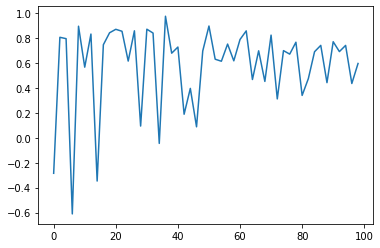

In [88]:
analysis = two_assets.groupby(['Year', 'Month'])[['lret_btc', 'lret_eth']].corr().dropna().loc[:,"lret_eth"].reset_index()

analysis[analysis['level_2'] == 'lret_btc']['lret_eth'].plot()